# Relatório de Produção

* Por se tratar de dados reais de uma empresa privada, eles foram alterados aleatoriamente utilizando o NumPy, de maneira a não refletir a realidade, com o objetivo de manter o sigilo das informações.

#### Filtro de Data

In [153]:
mes = [1,2,3,4,5,6,7,8,9]
ano = [2023]

#### Pipeline Aparas

In [154]:
# Bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import datetime


import warnings
warnings.filterwarnings("ignore")

from pandas.core.reshape.tile import to_datetime


In [ ]:
# Importando arquivos

mtc238 = r'c:\Users\alexm\Desktop\Relatorio_mensal-20231112T204354Z-001\Relatorio_mensal\MTC238.CSV'
mtr374 = r'c:\Users\alexm\Desktop\Relatorio_mensal-20231112T204354Z-001\Relatorio_mensal\MTR374.CSV'
gpc303 = r'c:\Users\alexm\Desktop\Relatorio_mensal-20231112T204354Z-001\Relatorio_mensal\GPC303.CSV'

f8 = pd.read_csv(mtc238, sep=';', encoding='latin1') # MTC238
movimentacoes = pd.read_csv(mtr374, sep=';', encoding='latin1') # MTR374
cons_op = pd.read_csv(gpc303, sep=';', encoding='latin1') # GPC303

In [ ]:
ops = cons_op.groupby('No da OP').agg({'Producao':'first', 'Descricao.3':'first'}).reset_index()

In [ ]:
ops.columns = ['OP', 'Data', 'Maquina']

In [ ]:
entradas = movimentacoes[['No Docto', 'Produto', 'Descricao', 'Lote Interno', 'Quantidade', 'Tipo']]
entradas.columns = ['OP_mov', 'Codigo_mov', 'Item', 'Lote', 'Peso', 'Movimento']

In [ ]:
entradas = entradas[entradas['Movimento'] == 'ENTRADA (+)']

In [ ]:
f8 = f8[['Codigo', 'Espessura', 'Largura', 'Comprimento', 'Descricao.1']]
f8.rename(columns={'Codigo': 'Codigo_f8', 'Descricao.1': 'Grupo'}, inplace=True)

In [ ]:
entradas['OP_mov'] = entradas['OP_mov'].str.replace('.','')
entradas['OP_mov'] = entradas['OP_mov'].astype(float)


In [ ]:
df = pd.merge(ops, entradas, left_on='OP', right_on='OP_mov', how='right')

In [ ]:
df = pd.merge(df, f8, left_on='Codigo_mov', right_on='Codigo_f8', how='left')
df.drop(columns=['OP_mov', 'Movimento', 'Codigo_f8'], inplace=True)

In [ ]:
df.Data = pd.to_datetime(df.Data, format='%d/%m/%Y')
df.Peso = df.Peso.str.replace(r'[^\d.]', '', regex=True)
df.Peso = df.Peso.str.replace('.','')
df = df[df['Peso']!='']
df.Peso = (df.Peso.astype(float)/1000).round(2)
df.Largura = df.Largura.str.replace(r'[^\d.]', '', regex=True)
df.Largura = df.Largura.str.replace('.','')
df.Largura = (df.Largura.astype(float))


In [ ]:
espessuras_padrao = [1.80, 1.90, 2.00, 2.25, 2.65, 3.00, 3.35, 4.25, 4.75, 6.30, 8.00, 9.50, 12.70]
df.loc[~df['Espessura'].isin(espessuras_padrao), 'Espessura'] = 'FORA PADRÃO'

df['Largura'] = df['Largura']/10

df['Comprimento'] = df['Comprimento']*1000
df.loc[~((df['Comprimento'] == 3000) | (df['Comprimento'] == 6000)), 'Comprimento'] = 'FORA PADRÃO'


In [ ]:
df['Comprimento'].unique()

array(['FORA PADRÃO', 6000.0, 3000.0], dtype=object)

In [ ]:
print(f'Tamanho do DataFrame antes do drop_duplicates: {df.shape}')
print(f'Aplicando drop_duplicated {df.drop_duplicates(subset="Lote", inplace=True)}')
print(f'Tamanho do DataFrame após o drop_duplicates: {df.shape}')


Tamanho do DataFrame antes do drop_duplicates: (137391, 11)
Aplicando drop_duplicated None
Tamanho do DataFrame após o drop_duplicates: (128807, 11)


In [ ]:
df.duplicated().sum()

0

In [ ]:
if ano != 0:
    df = df[df['Data'].dt.year.isin(ano)]

if mes != 0:
    df = df[df['Data'].dt.month.isin(mes)]

In [ ]:
agg_prod = df.groupby(['OP', 'Grupo']).agg({'Item': 'first',
                                            'Maquina': 'first',
                                            'Espessura': 'first',
                                            'Largura': 'first',
                                            'Comprimento': 'first',
                                            'Peso': 'sum',
                                            'Data': 'first',})
agg_prod = agg_prod.reset_index()

In [ ]:
# Alterando valores aleatóriamente
agg_prod['Peso'] = agg_prod['Peso'] * np.random.uniform(0.5, 1.5, size=len(agg_prod))


In [ ]:
df_chapa = agg_prod[agg_prod['Grupo']=='CHAPA']
op_chapa = df_chapa['OP']

df_aparas_chapa = agg_prod[(agg_prod['Grupo'] == 'SUCATA DE ACO') & (agg_prod['OP'].isin(op_chapa))]
df_aparas_chapa = df_aparas_chapa[['OP', 'Peso']]

In [ ]:
df_chapa = pd.merge(df_chapa, df_aparas_chapa, on='OP')

In [ ]:
df_chapa.rename(columns={'Peso_x': 'Chapa_boa', 'Peso_y':'Aparas'}, inplace=True)
df_chapa = df_chapa[['OP', 'Data', 'Grupo', 'Item', 'Maquina', 'Espessura', 'Largura', 'Comprimento', 'Chapa_boa', 'Aparas']]

df_chapa.loc[~((df_chapa['Largura'] == 1200) | (df_chapa['Largura'] == 1500)), 'Largura'] = 'FORA PADRÃO'

df_chapa['Total_produzido'] = df_chapa['Aparas'] + df_chapa['Chapa_boa']
df_chapa['Percentual_aparas'] = df_chapa['Aparas'] / df_chapa['Total_produzido']

In [ ]:
df_perfil = agg_prod[agg_prod['Grupo']=='PERFIL ROLETADO']
op_perfil = df_perfil['OP']

df_aparas_perfil = agg_prod[(agg_prod['Grupo'] == 'SUCATA DE ACO') & (agg_prod['OP'].isin(op_perfil))]
df_aparas_perfil = df_aparas_perfil[['OP', 'Peso']]

In [ ]:
df_perfil = pd.merge(df_perfil, df_aparas_perfil, on='OP')

In [ ]:
df_perfil.rename(columns={'Peso_x': 'Perfil_bom', 'Peso_y':'Aparas'}, inplace=True)
df_perfil = df_perfil[['OP', 'Data', 'Grupo', 'Item', 'Maquina', 'Espessura', 'Largura', 'Comprimento', 'Perfil_bom', 'Aparas']]

df_perfil['Total_produzido'] = df_perfil['Aparas'] + df_perfil['Perfil_bom']
df_perfil['Percentual_aparas'] = df_perfil['Aparas'] / df_perfil['Total_produzido']

#### Pipeline Aparas Chapa

In [ ]:
transverssais = ['CORTE TRANSVERSAL 1/2" 01', 'CORTE TRANSVERSAL GCR 6.30MM', 'CORTE TRANSVERSAL MARAFON 3.00MM']
df_chapa = df_chapa[df_chapa['Maquina'].isin(transverssais)]
df_chapa['Maquina'] = df_chapa['Maquina'].replace({
    'CORTE TRANSVERSAL 1/2" 01' : 'TRANSVERSAL 1/2',
    'CORTE TRANSVERSAL GCR 6.30MM': 'TRANSVERSAL GCR',
    'CORTE TRANSVERSAL MARAFON 3.00MM':'TRANSVERSAL MARAFON'
})

maquinas_chapa = df_chapa.groupby('Maquina')[['Total_produzido', 'Aparas']].sum().reset_index()
maquinas_chapa['Percentual_aparas'] = (maquinas_chapa['Aparas'] / maquinas_chapa['Total_produzido'])*100

maquinas_chapa_data = df_chapa.groupby(['Maquina', 'Data'])[['Total_produzido', 'Aparas']].sum().reset_index()
maquinas_chapa_data['Percentual_aparas'] = (maquinas_chapa_data['Aparas'] / maquinas_chapa_data['Total_produzido'])*100


In [ ]:
maquinas_chapa_data['Periodo'] = maquinas_chapa_data['Data'].dt.to_period('M')
maquinas_chapa_data.sort_values(by='Periodo', ascending=True, inplace=True)

maquinas_chapa_data['Periodo'] = maquinas_chapa_data['Periodo'].astype(str)

maquinas_chapa_data = maquinas_chapa_data.groupby(['Maquina', 'Periodo'])['Percentual_aparas'].mean().reset_index()

# Aparas de Chapa

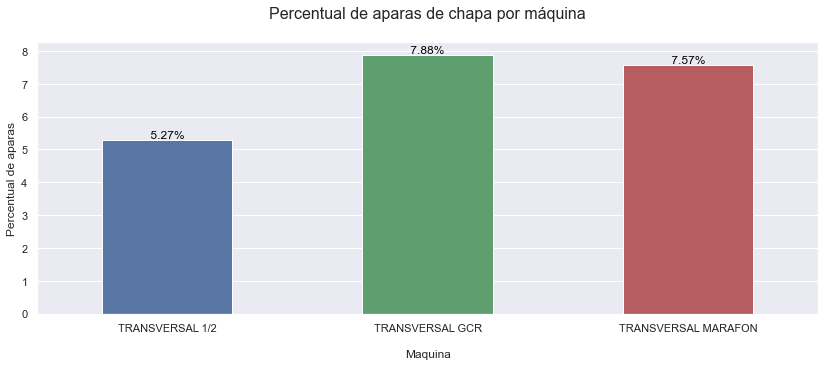

In [ ]:
plt.figure(figsize=(14, 5))
sns.set_theme(style="darkgrid")

ax = sns.barplot(data=maquinas_chapa, y='Percentual_aparas', x='Maquina', width=0.5, palette= ['b','g','r'])

ax.set_title('Percentual de aparas de chapa por máquina\n', fontsize=16)
ax.set_xlabel('\nMaquina', fontsize='12')
ax.set_ylabel('Percentual de aparas', fontsize='12')

for i, percentual in enumerate(maquinas_chapa['Percentual_aparas']):
    plt.text(i, percentual, f' {percentual:.2f}% ', ha='center', va='bottom', color='black')


plt.show()

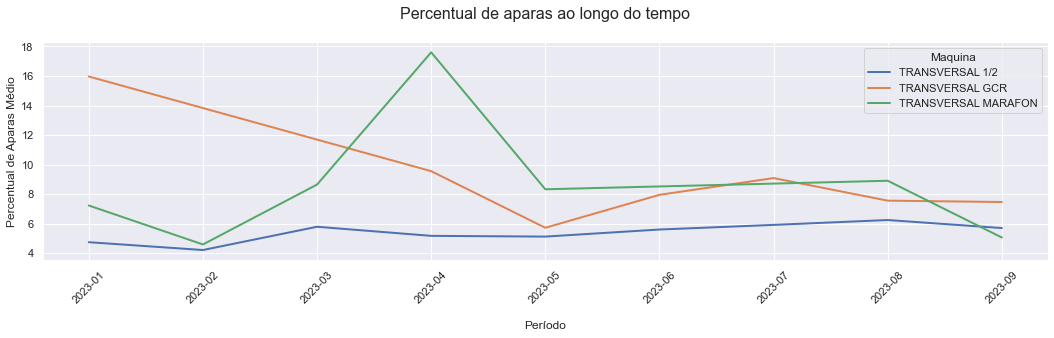

In [ ]:
plt.figure(figsize=(18, 4))

ax = sns.lineplot(x='Periodo', y="Percentual_aparas", hue="Maquina", data=maquinas_chapa_data, linewidth=2)

ax.set_title('Percentual de aparas ao longo do tempo\n', fontsize='16')#, palette=['b','g','r'])
ax.set_xlabel('\nPeríodo')
ax.set_ylabel('Percentual de Aparas Médio')

plt.xticks(rotation=45)

plt.show()


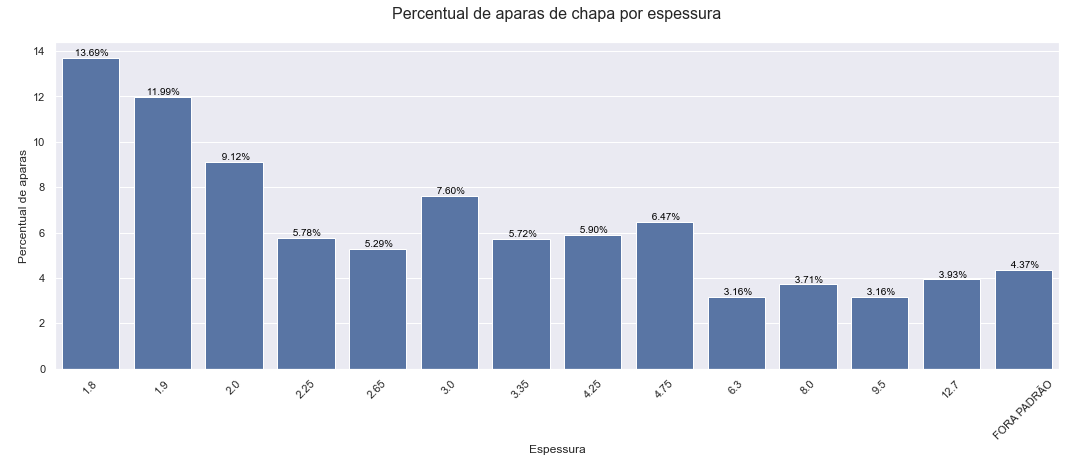

In [ ]:
espessura_chapa = df_chapa.groupby('Espessura')[['Total_produzido', 'Aparas']].sum().reset_index()
espessura_chapa['Percentual_aparas'] = (espessura_chapa['Aparas'] / espessura_chapa['Total_produzido'])*100

plt.figure(figsize=(18, 6))
ax = sns.barplot(data=espessura_chapa, y='Percentual_aparas', x='Espessura', color='b')

ax.set_title('Percentual de aparas de chapa por espessura\n', fontsize=16)
ax.set_ylabel('\nPercentual de aparas', fontsize='12')
ax.set_xlabel('Espessura', fontsize='12')

for i, percentual in enumerate(espessura_chapa['Percentual_aparas']):
    plt.text(i, percentual, f' {percentual:.2f}%', ha='center', va='bottom', color='black', fontsize=10)

plt.xticks(rotation=45)


plt.show()

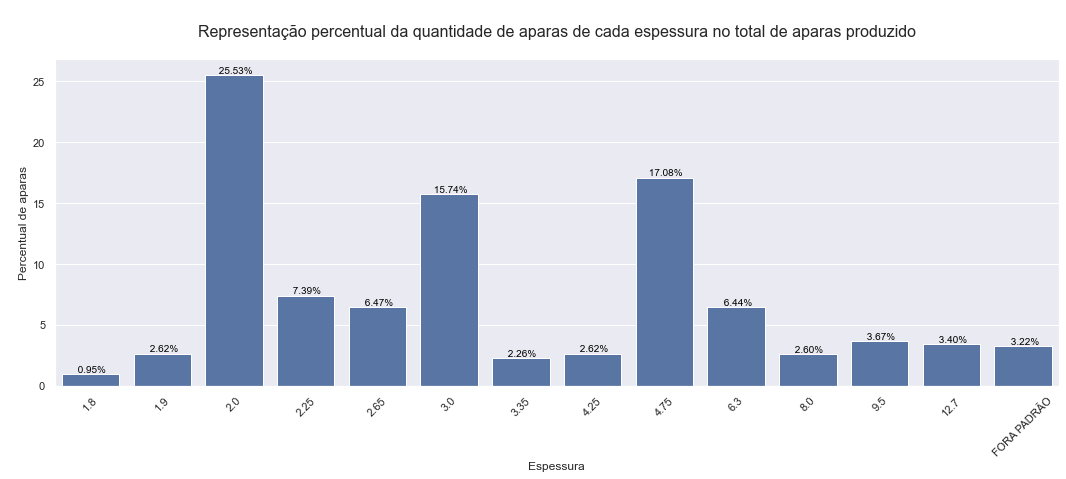

In [ ]:
df_chapa['Mes'] = df_chapa.Data.dt.month 

espessura_chapa_representacao = df_chapa.groupby('Espessura')[['Total_produzido', 'Aparas']].sum().reset_index()
espessura_chapa_representacao['Representacao_aparas'] = (espessura_chapa_representacao['Aparas'] / espessura_chapa_representacao['Aparas'].sum())*100

plt.figure(figsize=(18, 6))
ax = sns.barplot(data=espessura_chapa_representacao, y='Representacao_aparas', x='Espessura', color='b')

ax.set_title('\nRepresentação percentual da quantidade de aparas de cada espessura no total de aparas produzido\n', fontsize=16)
ax.set_ylabel('\nPercentual de aparas', fontsize='12')
ax.set_xlabel('Espessura', fontsize='12')

for i, percentual in enumerate(espessura_chapa_representacao['Representacao_aparas']):
    plt.text(i, percentual, f' {percentual:.2f}%', ha='center', va='bottom', color='black', fontsize=10)
plt.xticks(rotation=45)



plt.show()

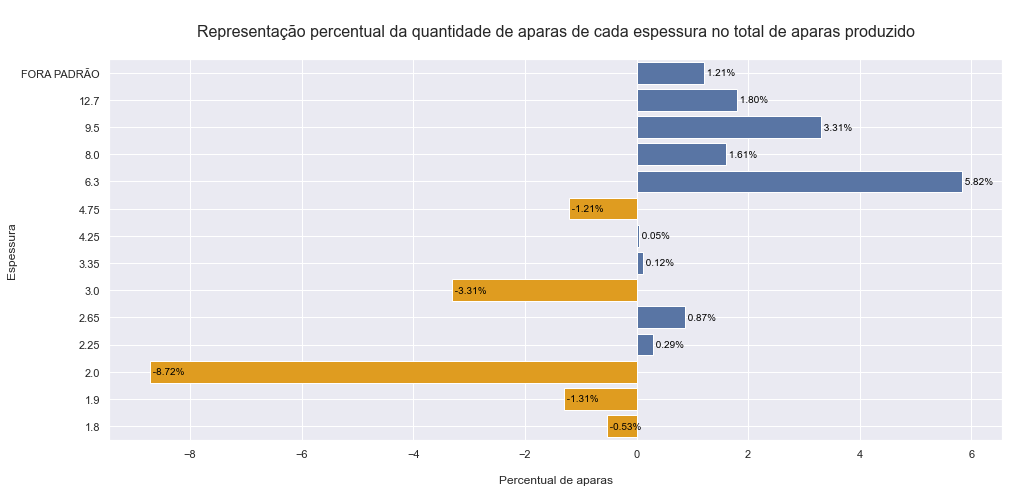

In [ ]:
espessura_chapa_peso = df_chapa.groupby('Espessura')[['Total_produzido', 'Aparas']].sum().reset_index()
espessura_chapa_peso['Representacao_aparas'] = (espessura_chapa_peso['Aparas'] / espessura_chapa_peso['Aparas'].sum())*100
espessura_chapa_peso['Representacao_producao'] = (espessura_chapa_peso['Total_produzido'] / espessura_chapa_peso['Total_produzido'].sum())*100
espessura_chapa_peso['Peso'] = espessura_chapa_peso['Representacao_producao'] - espessura_chapa_peso['Representacao_aparas']

plt.figure(figsize=(16, 7))
ax = sns.barplot(data=espessura_chapa_peso, x='Peso', y='Espessura',
                 palette=["orange" if p < 0 else "b" for p in espessura_chapa_peso['Peso']])

ax.set_title('\nRepresentação percentual da quantidade de aparas de cada espessura no total de aparas produzido\n', fontsize=16)
ax.set_xlabel('\nPercentual de aparas', fontsize='12')
ax.set_ylabel('Espessura', fontsize='12')

for i, percentual in enumerate(espessura_chapa_peso['Peso']):
    plt.text(percentual, i, f' {percentual:.2f}%', ha='left', va='center', color='black', fontsize=10)

ax.invert_yaxis()
ax.grid(True, which='both')


plt.show()

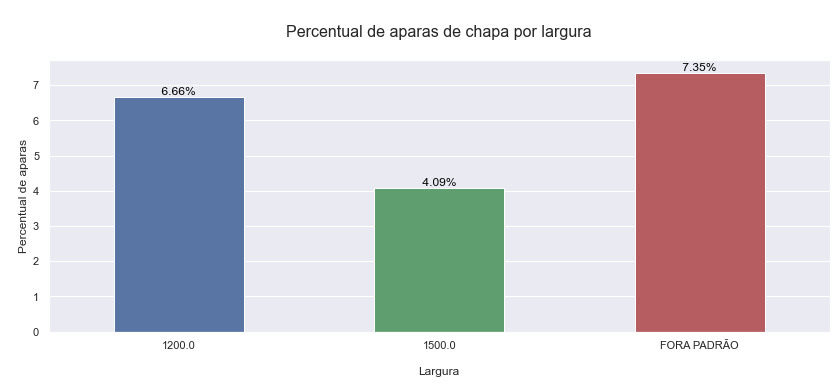

In [ ]:
largura_chapa = df_chapa.groupby('Largura')[['Total_produzido', 'Aparas']].sum().reset_index()
largura_chapa['Percentual_aparas'] = (largura_chapa['Aparas'] / largura_chapa['Total_produzido'])*100

plt.figure(figsize=(14,5))
ax = sns.barplot(data = largura_chapa, x = 'Largura', y = 'Percentual_aparas', width=0.5, palette= ['b','g','r'])
ax.set_title('\nPercentual de aparas de chapa por largura\n', fontsize=16)
ax.set_ylabel('\nPercentual de aparas', fontsize='12')
ax.set_xlabel('\nLargura', fontsize='12')

for i, percentual in enumerate(largura_chapa['Percentual_aparas']):
    plt.text(i, percentual, f' {percentual:.2f}% ', ha='center', va='bottom', color='black', fontsize=12)

plt.show()

#### Pipeline Aparas Perfil

In [ ]:
perfiladeiras = ['PERFILADEIRA PERFIL ROLETADO 3.00 PURLING HC-200H',
                  'PERFILADEIRA PERFIL ROLETADO 3.00 REGENTE 150',
                  'PERFILADEIRA PERFIL ROLETADO 3.00 MARAFON 200',
                  'PERFILADEIRA PERFIL ROLETADO 3.00 PURLIN HC-75H',
                  'PERFILADEIRA PERFIL ROLETADO 3.00 MARAFON 02',
                  'PERFILADEIRA PERFIL ROLET 3.00 ZIKELI PERFLEX UC75']
df_perfil = df_perfil[df_perfil['Maquina'].isin(perfiladeiras)]

df_perfil['Maquina'] = df_perfil['Maquina'].replace({
    'PERFILADEIRA PERFIL ROLETADO 3.00 PURLING HC-200H': 'PURLING 200',
    'PERFILADEIRA PERFIL ROLETADO 3.00 REGENTE 150': 'REGENTE',
    'PERFILADEIRA PERFIL ROLETADO 3.00 MARAFON 200': 'MARAFON 200',
    'PERFILADEIRA PERFIL ROLETADO 3.00 PURLIN HC-75H': 'PURLING 75',
    'PERFILADEIRA PERFIL ROLETADO 3.00 MARAFON 02': 'MARAFON 02',
    'PERFILADEIRA PERFIL ROLET 3.00 ZIKELI PERFLEX UC75': 'ZIKELI'
})

maquinas_perfil = df_perfil.groupby('Maquina')[['Total_produzido', 'Aparas']].sum().reset_index()
maquinas_perfil['Percentual_aparas'] = (maquinas_perfil['Aparas'] / maquinas_perfil['Total_produzido'])*100

maquinas_perfil_data = df_perfil.groupby(['Maquina', 'Data'])[['Total_produzido', 'Aparas']].sum().reset_index()
maquinas_perfil_data['Percentual_aparas'] = (maquinas_perfil_data['Aparas'] / maquinas_perfil_data['Total_produzido'])*100


In [ ]:
maquinas_perfil_data['Periodo'] = maquinas_perfil_data['Data'].dt.to_period('M')
maquinas_perfil_data.sort_values(by='Periodo', ascending=True, inplace=True)
maquinas_perfil_data['Periodo'] = maquinas_perfil_data['Periodo'].astype(str)

maquinas_perfil_data = maquinas_perfil_data.groupby(['Maquina', 'Periodo'])['Percentual_aparas'].mean().reset_index()

# Aparas de Perfil

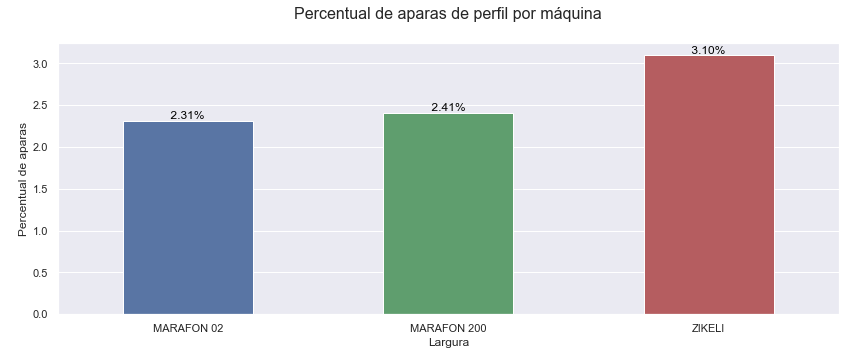

In [ ]:
plt.figure(figsize=(14,5))
ax = sns.barplot(data = maquinas_perfil, x = 'Maquina', y = 'Percentual_aparas', width=0.5, palette= ['b','g','r'])
ax.set_title('Percentual de aparas de perfil por máquina\n', fontsize=16)
ax.set_ylabel('\nPercentual de aparas')
ax.set_xlabel('Largura')

for i, percentual in enumerate(maquinas_perfil['Percentual_aparas']):
    plt.text(i, percentual, f' {percentual:.2f}% ', ha='center', va='bottom', color='black', fontsize=12)

plt.show()

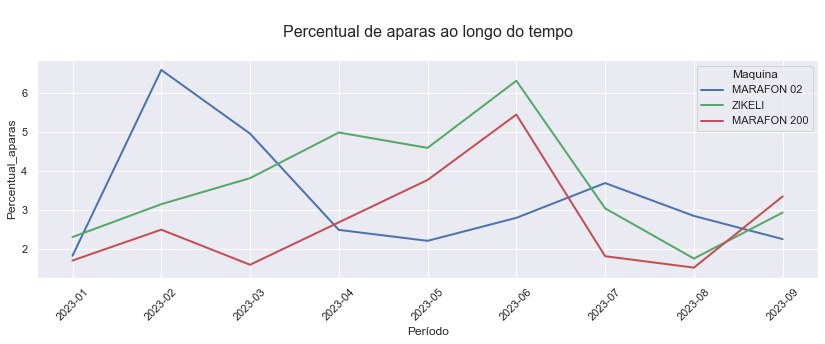

In [ ]:
maquinas_perfil_data = maquinas_perfil_data.sort_values(by='Periodo')

plt.figure(figsize=(14, 4))
ax = sns.lineplot(x='Periodo', y="Percentual_aparas", hue="Maquina", data=maquinas_perfil_data, linewidth=2, palette= ['b','g','r'])

ax.set_title('\nPercentual de aparas ao longo do tempo\n', fontsize='16')
ax.set_xlabel('Período')
ax.set_label('Percentual de Aparas Médio')

plt.xticks(rotation=45)




plt.show()

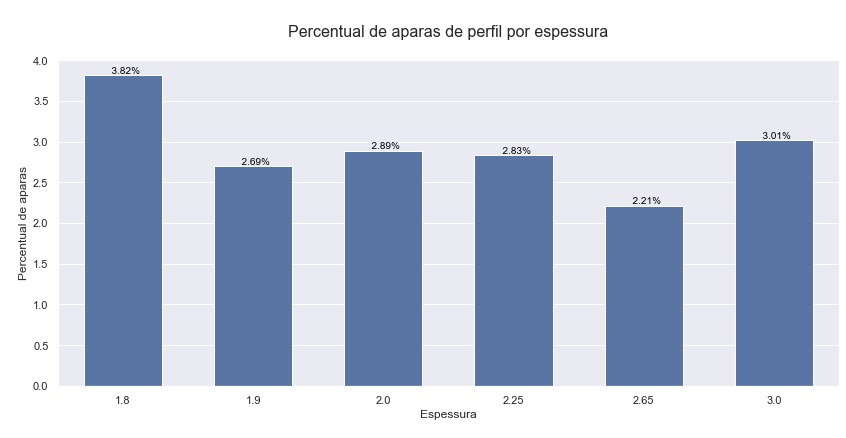

In [ ]:
espessura_perfil = df_perfil.groupby('Espessura')[['Total_produzido', 'Aparas']].sum().reset_index()
espessura_perfil['Percentual_aparas'] = (espessura_perfil['Aparas'] / espessura_perfil['Total_produzido'])*100

plt.figure(figsize=(14, 6))
ax = sns.barplot(data=espessura_perfil, y='Percentual_aparas', x='Espessura',  width=0.6)

ax.set_title('\nPercentual de aparas de perfil por espessura\n', fontsize=16)
ax.set_ylabel('\nPercentual de aparas', fontsize='12')
ax.set_xlabel('Espessura\n', fontsize='12')

for i, percentual in enumerate(espessura_perfil['Percentual_aparas']):
    plt.text(i, percentual, f'  {percentual:.2f}%', ha='center', va='bottom', color='black', fontsize=10)


plt.show()


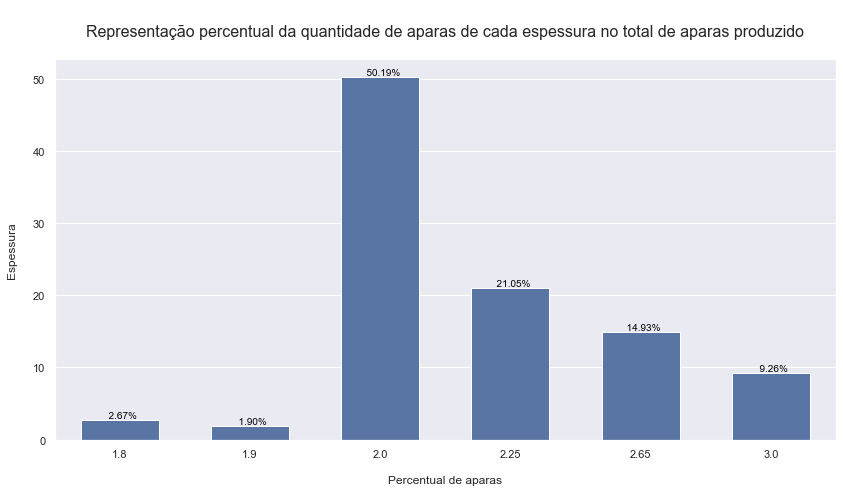

In [ ]:
espessura_perfil_representacao = df_perfil.groupby('Espessura')[['Total_produzido', 'Aparas']].sum().reset_index()
espessura_perfil_representacao['Representacao_aparas'] = (espessura_perfil_representacao['Aparas'] / espessura_perfil_representacao['Aparas'].sum())*100

plt.figure(figsize=(14, 7))
ax = sns.barplot(data=espessura_perfil_representacao, y='Representacao_aparas', x='Espessura',  width=0.6)

ax.set_title('\nRepresentação percentual da quantidade de aparas de cada espessura no total de aparas produzido\n', fontsize=16)
ax.set_xlabel('\nPercentual de aparas', fontsize='12')
ax.set_ylabel('Espessura\n', fontsize='12')

for i, percentual in enumerate(espessura_perfil_representacao['Representacao_aparas']):
    plt.text(i, percentual, f'  {percentual:.2f}%',  ha='center', va ='bottom', color='black', fontsize=10)

# ax.set_xlim((espessura_perfil_representacao['Representacao_aparas']).max() * 1.1,0)
# ax.invert_yaxis()


plt.show()

#### Pipeline Aparas Perfil

In [ ]:
df_perfil['Tipo_item'] = df_perfil['Item'].str.split(' ', n=0, expand=True)[0]
df_perfil['Espessura'] = df_perfil['Item'].str.split('X', n=0, expand=True)[0]
df_perfil['Espessura'] = df_perfil['Espessura'].str.split(' ', n=0, expand=True)[2]
df_perfil['Espessura'] = df_perfil['Espessura'].str.split('X', n=0, expand=True)[0]
df_perfil['Item_perfil'] = df_perfil['Item'].str.split(' ', n=0, expand=True)[2]
df_perfil['Item_perfil'] = df_perfil['Item_perfil'].str.split('X', n=1, expand=True)[1]
df_perfil['Comprimento'] = df_perfil['Item_perfil'].str.split('X').str[-1]
df_perfil = df_perfil.sort_values(by='Largura',ascending=True)

def extrair_parte(text):
    partes = text.split('X')
    if len(partes) > 1:
        return 'X'.join(partes[:-1])
    else:
        return text

df_perfil['Item_perfil'] = df_perfil['Item_perfil'].apply(extrair_parte)

df_perfil['Item_perfil'] = df_perfil['Item_perfil'].replace('100X50X20','100X50X17')
df_perfil['Item_perfil'] = df_perfil['Item_perfil'].replace('75X40X20','75X40X17')

## Aparas de Perfil por Item

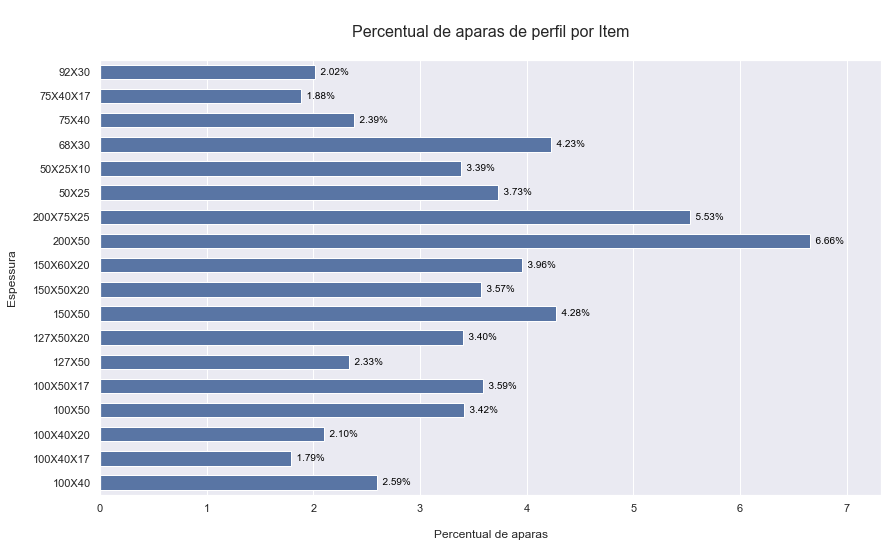

In [ ]:
tipo_perfil = df_perfil.groupby('Item_perfil')[['Total_produzido', 'Aparas']].sum().reset_index()
tipo_perfil['Percentual_aparas'] = (tipo_perfil['Aparas'] / tipo_perfil['Total_produzido'])*100

plt.figure(figsize=(14,8))
ax = sns.barplot(data=tipo_perfil, x='Percentual_aparas', y='Item_perfil', color='b', width=0.6)

ax.set_title('\nPercentual de aparas de perfil por Item\n', fontsize=16)
ax.set_xlabel('\nPercentual de aparas', fontsize='12')
ax.set_ylabel('Espessura\n', fontsize='12')

for i, percentual in enumerate(tipo_perfil['Percentual_aparas']):
    plt.text(percentual, i, f'  {percentual:.2f}%', ha='left', va='center', color='black', fontsize=10)

ax.set_xlim(0, (tipo_perfil['Percentual_aparas']).max() * 1.1)
ax.invert_yaxis()


plt.show()

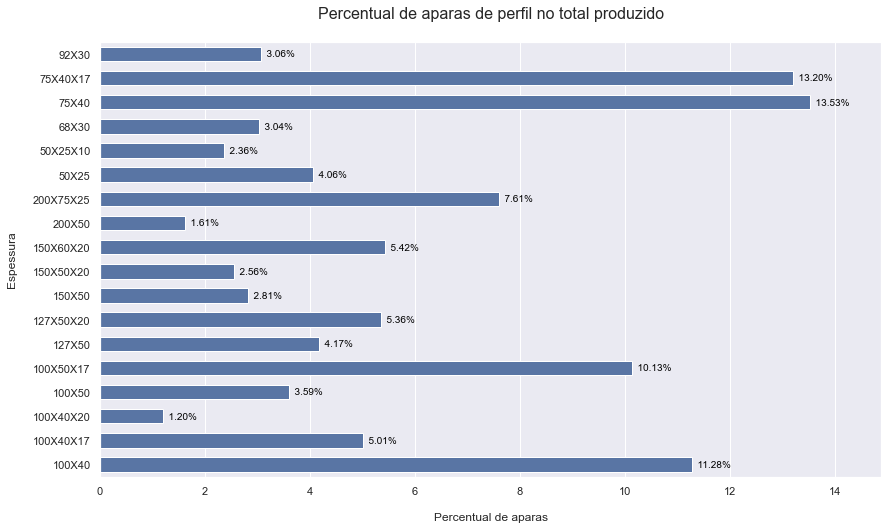

In [ ]:
tipo_item_representacao = df_perfil.groupby('Item_perfil')[['Total_produzido', 'Aparas']].sum().reset_index()
tipo_item_representacao['Percentual_aparas'] = (tipo_item_representacao['Aparas'] / tipo_item_representacao['Total_produzido'])*100
tipo_item_representacao['Representacao_aparas'] = (tipo_item_representacao['Aparas'] / tipo_item_representacao['Aparas'].sum())*100

plt.figure(figsize=(14,8))

ax = sns.barplot(data=tipo_item_representacao, y='Item_perfil', x='Representacao_aparas',  color='b', width=0.6)

ax.set_title('Percentual de aparas de perfil no total produzido\n', fontsize=16)
ax.set_xlabel('\nPercentual de aparas', fontsize='12')
ax.set_ylabel('Espessura\n', fontsize='12')

for i, percentual in enumerate(tipo_item_representacao['Representacao_aparas']):
    plt.text(percentual, i, f'  {percentual:.2f}%', ha='left', va='center', color='black', fontsize=10)

ax.set_xlim(0, (tipo_item_representacao['Representacao_aparas']).max() * 1.1)
ax.invert_yaxis()


plt.show()

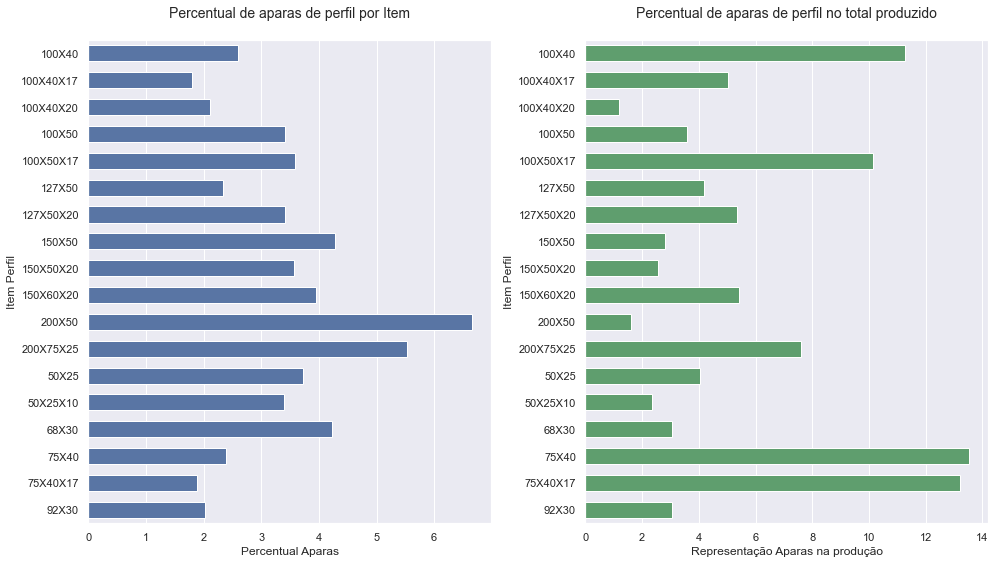

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 8))

sns.barplot(data=tipo_perfil, x='Percentual_aparas', y='Item_perfil', color='b', width=0.6, ax=axes[0])
sns.barplot(data=tipo_item_representacao, y='Item_perfil', x='Representacao_aparas', color='g', width=0.6, ax=axes[1])

axes[0].set_title('Percentual de aparas de perfil por Item\n', fontsize=14)
axes[0].set_xlabel('Percentual Aparas', fontsize=12)
axes[0].set_ylabel('Item Perfil', fontsize=12)

axes[1].set_title('Percentual de aparas de perfil no total produzido\n', fontsize=14)
axes[1].set_xlabel('Representação Aparas na produção', fontsize=12)
axes[1].set_ylabel('Item Perfil', fontsize=12)

plt.tight_layout()
ax.invert_yaxis()

plt.show()


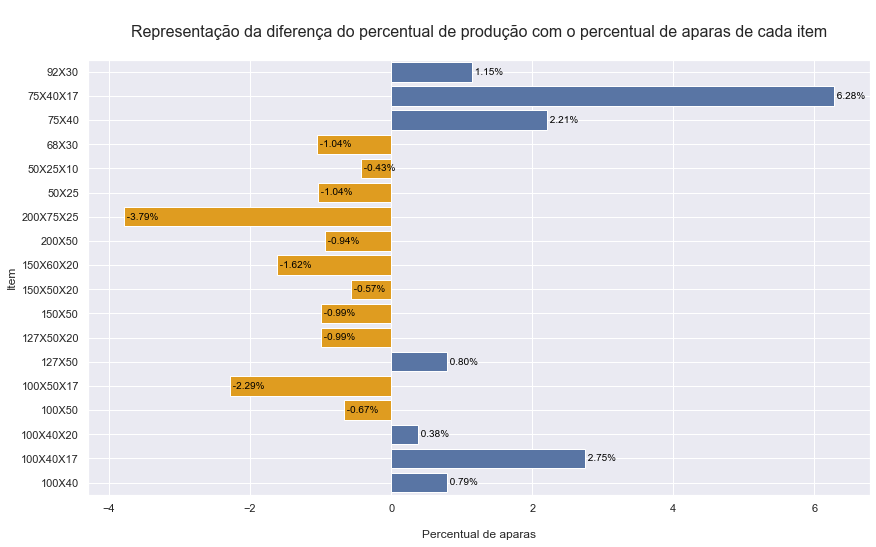

In [ ]:
tipo_item_representacao = df_perfil.groupby('Item_perfil')[['Total_produzido', 'Aparas']].sum().reset_index()
tipo_item_representacao['Percentual_aparas'] = (tipo_item_representacao['Aparas'] / tipo_item_representacao['Total_produzido'])*100
tipo_item_representacao['Representacao_aparas'] = (tipo_item_representacao['Aparas'] / tipo_item_representacao['Aparas'].sum())*100
tipo_item_representacao['Representacao_producao'] = (tipo_item_representacao['Total_produzido'] / tipo_item_representacao['Total_produzido'].sum())*100
tipo_item_representacao['Peso'] = tipo_item_representacao['Representacao_producao'] - tipo_item_representacao['Representacao_aparas']

plt.figure(figsize=(14, 8))
ax = sns.barplot(data=tipo_item_representacao, x='Peso', y='Item_perfil',
                palette=["orange" if p < 0 else "b" for p in tipo_item_representacao['Peso']])

ax.set_title('\nRepresentação da diferença do percentual de produção com o percentual de aparas de cada item\n', fontsize=16)
ax.set_xlabel('\nPercentual de aparas', fontsize='12')
ax.set_ylabel('Item', fontsize='12')

for i, percentual in enumerate(tipo_item_representacao['Peso']):
    plt.text(percentual, i, f' {percentual:.2f}%', ha='left', va='center', color='black', fontsize=10)

a = tipo_item_representacao['Peso'].max()*1.15
# ax.set_xlim(a*(-1),a)
ax.grid(True, which='both')
ax.invert_yaxis()


plt.show()

In [ ]:
df_perfil.to_csv(r'c:\Users\alexm\Desktop\Relatorio_mensal-20231112T204354Z-001\Relatorio_mensal\DataFrame_perfil.csv')
df_chapa.to_csv(r'c:\Users\alexm\Desktop\Relatorio_mensal-20231112T204354Z-001\Relatorio_mensal\DataFrame_chapa.csv')